# Methodology VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper

In [19]:
ship_name = "wPCC"
model = catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple']()

[11/05/24 12:43:53] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=205836;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=394924;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=290217;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=96038;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=934484;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=577475;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [20]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
df_VCT = model.prime(data=df_VCT)


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

[11/05/24 12:44:39] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=660064;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210856;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [21]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
meta_data_all = meta_data_all.loc[id_exists].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]
ids = [
        22773,
       # 22772,
        22770,
        #22765,
        #22774,
    ]

meta_datas = meta_data_all.loc[ids].copy()


[11/05/24 12:44:46] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=753264;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=1979;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=71057;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556153;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [26]:

dataframes = {}
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load("wPCC.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']

    df_EKF_smooth = model.prime(df_EKF_smooth)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    dataframes[name] = df_EKF_smooth

[11/05/24 12:45:38] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=988859;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=968578;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=261603;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=636984;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

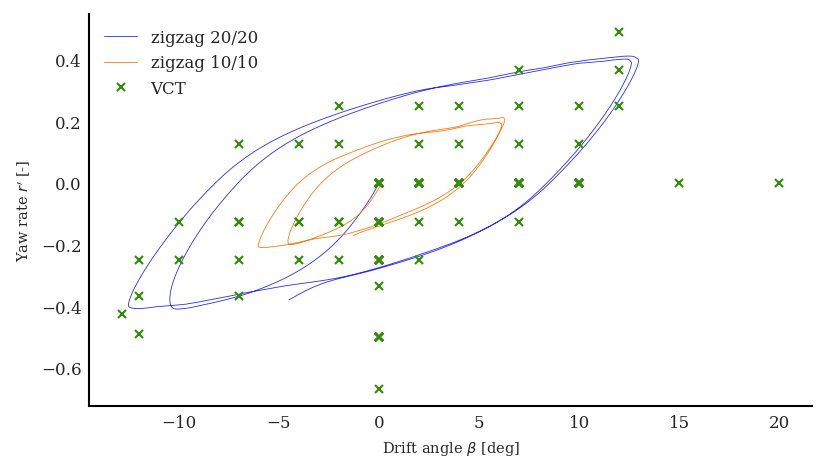

In [33]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r',ax=ax, label=name)

df_VCT.plot(x='beta_deg', y='r', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Yaw rate $r'$ [-]")

ax.legend(loc='upper left')
paper.save_fig(fig,"phase_plot.svg")

Text(0, 0.5, 'Rudder angle $\\delta$ [deg]')

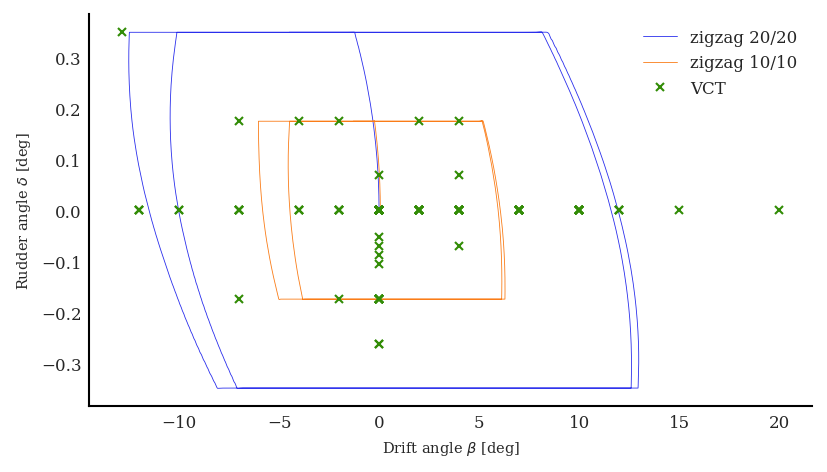

In [32]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='delta',ax=ax, label=name)

df_VCT.plot(x='beta_deg', y='delta', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Rudder angle $\delta$ [deg]")